# Modeling

## Objectives:
* Create a model that will predict the likelihood that an arrest will occur during a Terry Stop
* Deterimine which modeling method will bring about the best performance

## Import Data

In [436]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import warnings
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial.distance import euclidean
from sklearn.metrics import classification_report, confusion_matrix, precision_score, accuracy_score, recall_score, f1_score, roc_curve, auc
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.base import BaseEstimator
from sklearn.naive_bayes import BernoulliNB, CategoricalNB, GaussianNB, MultinomialNB

In [437]:
df = pd.read_csv('Terry_Stop_For_Modeling.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44750 entries, 0 to 44749
Data columns (total 39 columns):
 #   Column                                         Non-Null Count  Dtype 
---  ------                                         --------------  ----- 
 0   subject_id                                     44750 non-null  object
 1   go_sc_num                                      44750 non-null  int64 
 2   terry_stop_id                                  44750 non-null  int64 
 3   weapon_type                                    44750 non-null  object
 4   officer_yob                                    44750 non-null  int64 
 5   officer_race                                   44750 non-null  object
 6   subject_perceived_race                         44750 non-null  object
 7   initial_call_type                              44750 non-null  object
 8   final_call_type                                44750 non-null  object
 9   officer_squad                                  44203 non-null

In [438]:
for col in df.columns:
    df[col] = df[col].astype('category')


In [439]:
# df = df.astype({'subject_age_group': 'category', 'officer_gender':'category',
#                   'officer_race': 'category', 'subject_perceived_race':'category',
#                  'subject_perceived_gender' : 'category', 'repeat_offenders' : 'category',
#                  'arrest_made':'category', 'dif_race':'category', 'dif_gender':'category',
#                  'dif_race_gender':'category'})

In [440]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44750 entries, 0 to 44749
Data columns (total 39 columns):
 #   Column                                         Non-Null Count  Dtype   
---  ------                                         --------------  -----   
 0   subject_id                                     44750 non-null  category
 1   go_sc_num                                      44750 non-null  category
 2   terry_stop_id                                  44750 non-null  category
 3   weapon_type                                    44750 non-null  category
 4   officer_yob                                    44750 non-null  category
 5   officer_race                                   44750 non-null  category
 6   subject_perceived_race                         44750 non-null  category
 7   initial_call_type                              44750 non-null  category
 8   final_call_type                                44750 non-null  category
 9   officer_squad                          

In [441]:
df.describe()

,subject_id,go_sc_num,terry_stop_id,weapon_type,officer_yob,officer_race,subject_perceived_race,initial_call_type,final_call_type,officer_squad,...,frisk_flag__Y,dif_race__Y,dif_gender__Y,dif_race_gender__Y,repeat_offenders__Y,subject_age_group__1_17,subject_age_group__26_35,subject_age_group__36_45,subject_age_group__46_55,subject_age_group__56_100
count,44750,44750,44750,44750,44750,44750,44750,44750,44750,44203,...,44750,44750,44750,44750,44750,44750,44750,44750,44750,44750
unique,7911,34979,44750,21,50,8,8,165,204,168,...,2,2,2,2,2,2,2,2,2,2
top,unassigned,20160000378750,17551783994,None,1986,White,White,Unknown,Unknown,TRAINING - FIELD TRAINING SQUAD,...,0,1,0,1,0,0,0,0,0,0
freq,34688,16,1,32558,3151,34088,21870,13003,13003,4725,...,34809,26906,32202,31918,34688,42816,28456,35314,38990,42473


In [442]:
df = df.drop(['subject_id', 'go_sc_num', 'terry_stop_id', 'initial_call_type',
             'final_call_type', 'officer_yob','officer_squad','reported_hour',
             'arrest_made','weapon_type', 'subject_perceived_race', 'precinct',
             'sector','beat','officer_race'], axis=1)

In [443]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44750 entries, 0 to 44749
Data columns (total 24 columns):
 #   Column                                         Non-Null Count  Dtype   
---  ------                                         --------------  -----   
 0   weapon                                         44750 non-null  category
 1   incident_year                                  44750 non-null  category
 2   incident_month                                 44750 non-null  category
 3   officer_age                                    44750 non-null  category
 4   call_made                                      44750 non-null  category
 5   12am_6am                                       44750 non-null  category
 6   7am_12pm                                       44750 non-null  category
 7   1pm_6pm                                        44750 non-null  category
 8   7pm_11pm                                       44750 non-null  category
 9   officer_gender__M                      

In [444]:
# for col in df.columns:
#     df[col] = df[col].astype('float')


In [445]:
df.arrest_flag__Y.value_counts()

0    42133
1     2617
Name: arrest_flag__Y, dtype: int64

In [446]:
# Create X and y
y = df['arrest_flag__Y']
X = df.drop(['arrest_flag__Y'], axis=1)

In [447]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [448]:
df.head()

,weapon,incident_year,incident_month,officer_age,call_made,12am_6am,7am_12pm,1pm_6pm,7pm_11pm,officer_gender__M,...,frisk_flag__Y,dif_race__Y,dif_gender__Y,dif_race_gender__Y,repeat_offenders__Y,subject_age_group__1_17,subject_age_group__26_35,subject_age_group__36_45,subject_age_group__46_55,subject_age_group__56_100
0,0,2015,10,31,0,0,1,0,0,1,...,0,1,0,1,0,0,1,0,0,0
1,0,2015,3,50,0,0,1,0,0,1,...,0,1,1,1,0,0,1,0,0,0
2,0,2015,3,54,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
3,0,2015,4,52,0,1,0,0,0,1,...,0,1,1,1,0,0,1,0,0,0
4,0,2015,4,38,0,1,0,0,0,1,...,0,1,0,1,0,0,1,0,0,0


In [449]:
# creating df with continuous features
cont_feat = X.select_dtypes(exclude = ['object', 'category'])

# removing object and categoricals features in X_train and X_test
X_train_cont = X_train.select_dtypes(exclude = ['object', 'category'])
X_test_cont = X_test.select_dtypes(exclude = ['object', 'category'])

In [450]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [456]:




# Remove object-type features from X
cont_features = X.select_dtypes(exclude = ['object'])

# Remove object-type features X_train and X_test
X_train_cont = X_train.select_dtypes(exclude = ['object'])
X_test_cont = X_test.select_dtypes(exclude = ['object'])


In [452]:
df.head()

,weapon,incident_year,incident_month,officer_age,call_made,12am_6am,7am_12pm,1pm_6pm,7pm_11pm,officer_gender__M,...,frisk_flag__Y,dif_race__Y,dif_gender__Y,dif_race_gender__Y,repeat_offenders__Y,subject_age_group__1_17,subject_age_group__26_35,subject_age_group__36_45,subject_age_group__46_55,subject_age_group__56_100
0,0,2015,10,31,0,0,1,0,0,1,...,0,1,0,1,0,0,1,0,0,0
1,0,2015,3,50,0,0,1,0,0,1,...,0,1,1,1,0,0,1,0,0,0
2,0,2015,3,54,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
3,0,2015,4,52,0,1,0,0,0,1,...,0,1,1,1,0,0,1,0,0,0
4,0,2015,4,38,0,1,0,0,0,1,...,0,1,0,1,0,0,1,0,0,0


In [457]:
# Scale the train and test data
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train_cont)
X_test_ss = ss.transform(X_test_cont)

In [458]:
# Create a dataframe only containing the object-type features

X_train_cat = X_train.select_dtypes(include = ['object'])
X_test_cat = X_test.select_dtypes(include = ['object'])

In [459]:
from sklearn.preprocessing import OneHotEncoder

# OneHotEncode categorical variables
ohe = OneHotEncoder(handle_unknown='ignore')

# Transform training and test sets
X_train_ohe = ohe.fit_transform(X_train_cat)
X_test_ohe = ohe.transform(X_test_cat)

# Convert these columns into a DataFrame
columns = ohe.get_feature_names(input_features=X_train_cat.columns) # Build an array of column names
cat_train_df = pd.DataFrame(X_train_ohe.todense(), columns=columns) # Return a dense version of the dataframe
cat_test_df = pd.DataFrame(X_test_ohe.todense(), columns=columns)

In [460]:
# Get the column names of the continuous features
col = cont_features.columns

In [463]:
# Create an X-Train dataframe
dff = pd.DataFrame(X_train_ss, columns=col)
dff.head()

,weapon,incident_year,incident_month,officer_age,call_made,12am_6am,7am_12pm,1pm_6pm,7pm_11pm,officer_gender__M,...,frisk_flag__Y,dif_race__Y,dif_gender__Y,dif_race_gender__Y,repeat_offenders__Y,subject_age_group__1_17,subject_age_group__26_35,subject_age_group__36_45,subject_age_group__46_55,subject_age_group__56_100
0,1.626916,1.575888,1.065020,-1.024117,0.638964,-0.644378,-0.504819,1.554230,-0.516736,0.357376,...,-0.535894,-1.226175,-0.623962,-1.574716,1.851406,-0.210497,-0.756009,1.925397,-0.385228,-0.22984
1,-0.614660,-0.890505,0.454488,0.398683,0.638964,1.551885,-0.504819,-0.643405,-0.516736,0.357376,...,1.866040,0.815544,-0.623962,0.635035,-0.540130,-0.210497,-0.756009,1.925397,-0.385228,-0.22984
2,-0.614660,-0.890505,-1.682374,-0.194150,0.638964,-0.644378,-0.504819,1.554230,-0.516736,0.357376,...,-0.535894,0.815544,-0.623962,0.635035,-0.540130,-0.210497,-0.756009,-0.519373,2.595868,-0.22984
3,1.626916,0.342691,-0.156044,1.584350,0.638964,-0.644378,-0.504819,1.554230,-0.516736,0.357376,...,1.866040,-1.226175,-0.623962,-1.574716,-0.540130,-0.210497,-0.756009,-0.519373,-0.385228,-0.22984
4,-0.614660,0.342691,-0.766576,-0.431283,0.638964,-0.644378,-0.504819,1.554230,-0.516736,0.357376,...,-0.535894,0.815544,-0.623962,0.635035,-0.540130,-0.210497,-0.756009,-0.519373,-0.385228,-0.22984


In [464]:
# Combine scaled training data and categorcial data

X_train_all = pd.concat([pd.DataFrame(X_train_ss, columns=col), cat_train_df], axis=1)
X_test_all = pd.concat([pd.DataFrame(X_test_ss, columns=col), cat_test_df], axis=1)

In [465]:
X_test_all.head() # display the first 5 rows

,weapon,incident_year,incident_month,officer_age,call_made,12am_6am,7am_12pm,1pm_6pm,7pm_11pm,officer_gender__M,...,frisk_flag__Y,dif_race__Y,dif_gender__Y,dif_race_gender__Y,repeat_offenders__Y,subject_age_group__1_17,subject_age_group__26_35,subject_age_group__36_45,subject_age_group__46_55,subject_age_group__56_100
0,-0.614660,-0.890505,-0.156044,-0.075584,0.638964,1.551885,-0.504819,-0.643405,-0.516736,0.357376,...,-0.535894,0.815544,1.602663,0.635035,-0.540130,4.750665,-0.756009,-0.519373,-0.385228,-0.229840
1,1.626916,0.959290,-0.156044,-0.668417,0.638964,-0.644378,1.980909,-0.643405,-0.516736,0.357376,...,-0.535894,0.815544,-0.623962,0.635035,1.851406,-0.210497,-0.756009,1.925397,-0.385228,-0.229840
2,-0.614660,0.342691,0.454488,1.702916,-1.565034,1.551885,-0.504819,-0.643405,-0.516736,0.357376,...,-0.535894,0.815544,-0.623962,0.635035,-0.540130,-0.210497,-0.756009,-0.519373,-0.385228,-0.229840
3,1.626916,1.575888,0.149222,-0.312717,0.638964,1.551885,-0.504819,-0.643405,-0.516736,0.357376,...,-0.535894,-1.226175,-0.623962,-1.574716,1.851406,-0.210497,-0.756009,-0.519373,-0.385228,4.350854
4,1.626916,1.575888,-1.682374,0.042983,0.638964,1.551885,-0.504819,-0.643405,-0.516736,0.357376,...,-0.535894,0.815544,-0.623962,0.635035,1.851406,-0.210497,1.322736,-0.519373,-0.385228,-0.229840


In [466]:
# Check for class imbalance
print(y_train.value_counts())

# Fit SMOTE to training data
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train_all, y_train)

# Preview synthetic sample class distrubution
print('\n')
print(pd.Series(y_train_resampled).value_counts())

0    31588
1     1974
Name: arrest_flag__Y, dtype: int64


1    31588
0    31588
Name: arrest_flag__Y, dtype: int64


### Modeling

#### Using a pipeline for four methods: KNClassifier, Random Forest, AdaBoost, and GradientBoosing

In [467]:
from sklearn.pipeline import Pipeline
# Create a list of classifiers
classifiers = [KNeighborsClassifier(), 
               RandomForestClassifier(), AdaBoostClassifier(), 
              GradientBoostingClassifier()]
# Build a for loop to instaniate the classification models and loop through the classifiers
for classifier in classifiers:
    pipe = Pipeline(steps=[('classifier', classifier)])
    pipe.fit(X_train_resampled, y_train_resampled) # Fit each model to the training data
    print(classifier) #Print the classifer results with parameters
    print('model score: %.3f' %pipe.score(X_test_all, y_test)) # Returns the coefficient of determination (R^2) of the prediction

KNeighborsClassifier()
model score: 0.874
RandomForestClassifier()
model score: 0.915
AdaBoostClassifier()
model score: 0.840
GradientBoostingClassifier()
model score: 0.854


In [468]:
# Guess and Check: Select Parameters
grid = {"classifier__n_estimators": [5, 10],
        "classifier__min_samples_leaf": [0.10, 1]}

In [469]:
# Run GridSearchCV and Cross Validation with the choosen parameters
gridsearch = GridSearchCV(estimator=pipe, param_grid=grid, 
                          scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

In [470]:
# Fit Model
gridsearch.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.8s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__min_samples_leaf': [0.1, 1],
                         'classifier__n_estimators': [5, 10]},
             scoring='accuracy', verbose=1)

In [471]:
# Find the best paramters for the model
gridsearch.best_params_

{'classifier__min_samples_leaf': 0.1, 'classifier__n_estimators': 5}

In [473]:
# find best estimator 
gridsearch.best_estimator_

Pipeline(steps=[('classifier',
                 GradientBoostingClassifier(min_samples_leaf=0.1,
                                            n_estimators=5))])

In [474]:
gridsearch.best_score_

0.9112637431535553

#### Base Estimator using sklearn with ClfSwitcher

In [475]:
# Create a child class to use multiple baseline models to use with the Pipeline Function
from sklearn.base import BaseEstimator
class ClfSwitcher(BaseEstimator):

    def __init__(self, estimator=None):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """ 

        self.estimator = estimator


    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self


    def predict(self, X, y=None):
        return self.estimator.predict(X)


    def predict_proba(self, X):
        return self.estimator.predict_proba(X)


    def score(self, X, y):
        return self.estimator.score(X, y)

In [476]:
# Create a  Pipeline using "ClfSwitcher"
pipeline_clf = Pipeline([('clf', ClfSwitcher())])

In [477]:
# Set parameters for each classification model
parameters = [
{
    'clf__estimator': [KNeighborsClassifier()],
    'clf__estimator__n_neighbors': [3, 5],
    'clf__estimator__weights': ['uniform', 'distance']
},
{   'clf__estimator': [RandomForestClassifier()],
    'clf__estimator__criterion': ['gini', 'entropy'],
    'clf__estimator__min_samples_split': [2, 5], 
    'clf__estimator__max_depth': [3, 5]
},  
{   'clf__estimator': [AdaBoostClassifier()],
    'clf__estimator__n_estimators': [2, 4]
},
{   'clf__estimator': [GradientBoostingClassifier()],
    'clf__estimator__min_samples_leaf': [1, 3] 
}
]

In [478]:
# Run a GridSearch using the paramters do cross validation for each iteration of each classifier
gridsearch_final = GridSearchCV(pipeline_clf, param_grid=parameters, n_jobs=-1, verbose=1, cv=3)

In [479]:
# fit the models
gridsearch_final.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  2.3min finished


GridSearchCV(cv=3, estimator=Pipeline(steps=[('clf', ClfSwitcher())]),
             n_jobs=-1,
             param_grid=[{'clf__estimator': [KNeighborsClassifier(weights='distance')],
                          'clf__estimator__n_neighbors': [3, 5],
                          'clf__estimator__weights': ['uniform', 'distance']},
                         {'clf__estimator': [RandomForestClassifier()],
                          'clf__estimator__criterion': ['gini', 'entropy'],
                          'clf__estimator__max_depth': [3, 5],
                          'clf__estimator__min_samples_split': [2, 5]},
                         {'clf__estimator': [AdaBoostClassifier()],
                          'clf__estimator__n_estimators': [2, 4]},
                         {'clf__estimator': [GradientBoostingClassifier()],
                          'clf__estimator__min_samples_leaf': [1, 3]}],
             verbose=1)

In [480]:
# Find the best best estimator
best_pipeline = gridsearch_final.best_estimator_

In [481]:
# Find the best performing model
best_pipeline['clf']

ClfSwitcher(estimator=KNeighborsClassifier(weights='distance'))

### Evaluation Part 1: best_pipeline

In [482]:
# Returns the coefficient of determination (R^2) of the prediction
best_pipeline.score(X_train_resampled, y_train_resampled), best_pipeline.score(X_test_all, y_test)

(0.995029758136001, 0.8904183053271362)

In [483]:
# Find the best parameters
gridsearch_final.best_params_

{'clf__estimator': KNeighborsClassifier(weights='distance'),
 'clf__estimator__n_neighbors': 5,
 'clf__estimator__weights': 'distance'}

### Use GradientBoostClassifier -best performing model

In [484]:
# Initiate Gradient Boosting Classifier
best_mod = GradientBoostingClassifier()

In [485]:
# Fit model to resampled training data
best_mod.fit(X_train_resampled, y_train_resampled)

GradientBoostingClassifier()

In [486]:
# Calculate the probability scores of each point in the training set- solve for error
y_scores = best_mod.decision_function(X_train_resampled)

In [487]:
# Make Predictions 
y_hat_test = best_mod.predict(X_test_all)

In [488]:
# Calculate the False Positive Rate (FPR), True Posititve
# Rate (TPR), and Threshold for the training data and training predictions
fpr, tpr, thresh = roc_curve(y_train_resampled, y_scores)

# Calculate the ROC (Reciever Operating Characteristic) AUC (Area Under the Curve)
rocauc = auc(fpr, tpr)

print('Train FPR: ', fpr)
print('Train TPR: ', tpr)
print('Train ROC AUC Score: ', rocauc)

Train FPR:  [0.         0.         0.         ... 0.99987337 0.99996834 1.        ]
Train TPR:  [0.00000000e+00 6.33151830e-05 1.26630366e-04 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
Train ROC AUC Score:  0.990988129601826


In [490]:
# Calculate the False Positive Rate (FPR), True Posititve
# Rate (TPR), and Threshold for the testing data and testing predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_hat_test)
roc_auc = auc(false_positive_rate, true_positive_rate)

# print('Training Root Mean Square Error', np.sqrt(mean_squared_error(y_resampled_train, y_scores)))
#print('Testing Root Mean Square Error', np.sqrt(mean_squared_error(y_test, y_hat_test)))
print('Test FPR: ', false_positive_rate)
print('Test TPR: ', true_positive_rate)
print('Test ROC AUC Score: ', roc_auc)

Test FPR:  [0.         0.14452347 1.        ]
Test TPR:  [0.         0.83825816 1.        ]
Test ROC AUC Score:  0.8468673470064974


Testing AUC: 0.8468673470064974


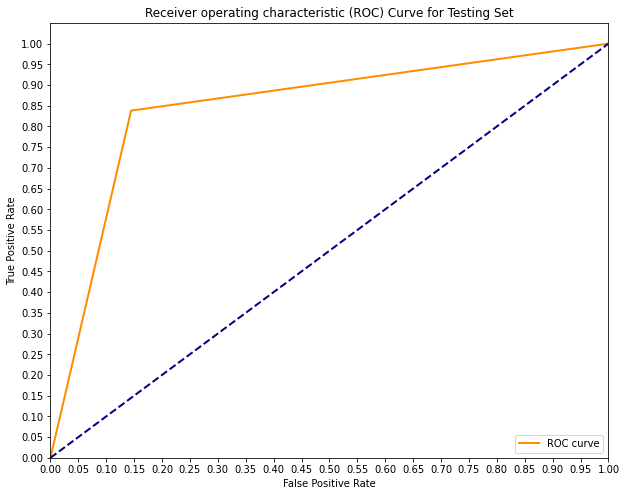

In [492]:
# ROC curve for testing set
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(false_positive_rate, true_positive_rate, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Testing Set')
plt.legend(loc='lower right')
print('Testing AUC: {}'.format(auc(false_positive_rate, true_positive_rate)))
plt.show()

In [493]:
# Compute a confusion matrix to evaluate the accuracy of the model classifications
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix:\n', cnf_matrix)
print('classification report:\n ', classification_report(y_test, y_hat_test)) # Build a text report showing the main classification metrics

Confusion Matrix:
 [[9021 1524]
 [ 104  539]]
classification report:
                precision    recall  f1-score   support

           0       0.99      0.86      0.92     10545
           1       0.26      0.84      0.40       643

    accuracy                           0.85     11188
   macro avg       0.62      0.85      0.66     11188
weighted avg       0.95      0.85      0.89     11188



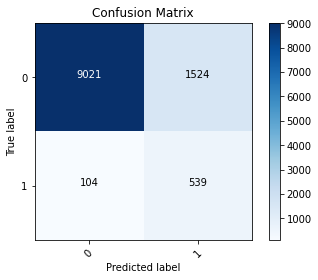

In [497]:
import itertools
# Create the basic confusion matrix
plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) 

# Add title and axis labels
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add appropriate axis scales
class_names = set(y) # Get class labels to add to matrix
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add labels to each cell
thresh = cnf_matrix.max() / 2. # Used for text coloring below
# Here we iterate through the confusion matrix and append labels to our visualization 
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment='center',
                 color='white' if cnf_matrix[i, j] > thresh else 'black')

# Add a legend
plt.colorbar()
plt.show()

In [498]:
# Print the Y_test (Actual) data and Y_hat (Predictions) response values.
# Compare the two to check for overfitting

print('Actual:', y_test.values[:35])
print('Prediction:', y_hat_test[:35])


Actual: [0, 1, 0, 0, 0, ..., 0, 0, 0, 0, 0]
Length: 35
Categories (2, int64): [0, 1]
Prediction: [0 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1]


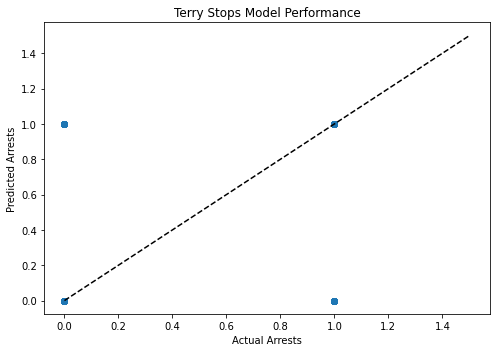

In [499]:
# Plot Model Performance
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_hat_test)
plt.plot([0, 1.5], [0, 1.5], '--k') # Plot line of best fit
plt.axis('tight') #  resize subplots in a figure so that there 
                  # are no overlaps between axes objects and labels on the axes.
plt.title('Terry Stops Model Performance')
plt.xlabel('Actual Arrests')
plt.ylabel('Predicted Arrests')
plt.tight_layout()

### Best Features Model

In [500]:
# Score and rank the features by importance (most relevant features)
best_mod.feature_importances_

array([1.02869160e-14, 2.94692799e-02, 4.45895412e-02, 2.81448714e-02,
       7.21667979e-04, 0.00000000e+00, 5.32559213e-04, 0.00000000e+00,
       4.57318361e-04, 7.25739303e-04, 3.42429652e-04, 7.05770231e-05,
       0.00000000e+00, 1.88256968e-03, 1.45793594e-04, 7.66594794e-04,
       0.00000000e+00, 8.89775688e-01, 0.00000000e+00, 1.95135158e-03,
       3.31389605e-04, 5.96178658e-05, 3.30105326e-05])

In [501]:
def plot_feature_importances(model, X_train):
    """
    Input: the model, X training data
    Output: A plot of the features by 
    their assigned importance
    
    """
    feature_importances = model.feature_importances_
    features = X_train.columns
    plt.bar(features, feature_importances)
    plt.xlabel("Feature Names")
    plt.ylabel("Feature Importance\nScores")
    plt.tight_layout()
    plt.title("Feature Importances\nBar Chart")
    plt.xticks(rotation=85)
    plt.show()

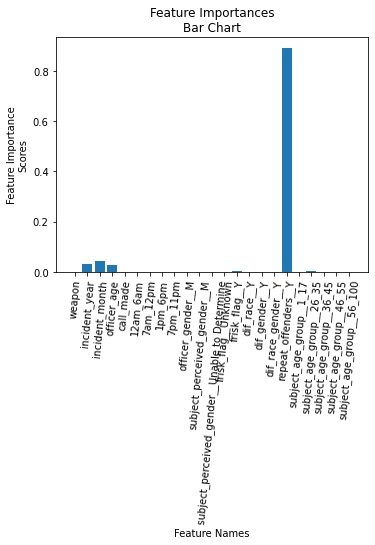

In [502]:
# Call Function
plot_feature_importances(model=best_mod, X_train=X_train_all)

In [505]:
# Create a list of the best feature column names and index into the X testing and training dataframes
best_feats = ['weapon', 'repeat_offenders__Y', 'incident_year', 'incident_month', 'officer_age']
X_feat_train = X_train_all[best_feats]
X_feat_test = X_test_all[best_feats]

In [506]:
# Check for class imbalance
print(y_train.value_counts())

# Fit SMOTE to training data
smote = SMOTE()
X_feat_resampled, y_feat_resampled = smote.fit_sample(X_feat_train, y_train)

# Preview synthtic sample class distrubution
print('\n')
print(pd.Series(y_feat_resampled).value_counts())

0    31588
1     1974
Name: arrest_flag__Y, dtype: int64


1    31588
0    31588
Name: arrest_flag__Y, dtype: int64


In [507]:
# Fit the model
best_mod.fit(X_feat_resampled, y_feat_resampled)

GradientBoostingClassifier()

In [508]:
# Make predictions
y_hat_feat = best_mod.predict(X_feat_test)

## Evaluation Part 2: best_mod(w/best features)

In [509]:
# R^2 Score 
best_mod.score(X_feat_test, y_test)

0.8367894172327494

In [511]:
# Calculate the False Positive Rate (FPR), True Posititve
# Rate (TPR), and Threshold for the testing data and testing predictions

fpr, tpr, thresh = roc_curve(y_test, y_hat_feat)
rocauc = auc(fpr, tpr)

# print('Training Root Mean Square Error', np.sqrt(mean_squared_error(y_resampled_train, y_scores)))
#print('Testing Root Mean Square Error', np.sqrt(mean_squared_error(y_test, y_hat_feat)))
print('Test FPR: ', fpr)
print('Test TPR: ', tpr)
print('Test ROC AUC Score: ', rocauc)

Test FPR:  [0.        0.1730678 1.       ]
Test TPR:  [0.         0.99844479 1.        ]
Test ROC AUC Score:  0.9126884926999521


Testing AUC: 0.9126884926999521


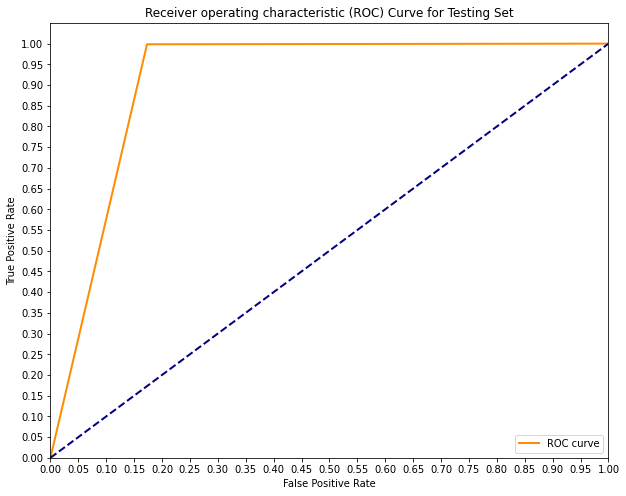

In [512]:
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Testing Set')
plt.legend(loc='lower right')
print('Testing AUC: {}'.format(auc(fpr, tpr)))
plt.show()

In [513]:
# Compute confusion matrix and print the classification report
cf_matrix = confusion_matrix(y_test, y_hat_feat)
print('Confusion Matrix:\n', cf_matrix)
print('classification report:\n ', classification_report(y_test, y_hat_test))

Confusion Matrix:
 [[8720 1825]
 [   1  642]]
classification report:
                precision    recall  f1-score   support

           0       0.99      0.86      0.92     10545
           1       0.26      0.84      0.40       643

    accuracy                           0.85     11188
   macro avg       0.62      0.85      0.66     11188
weighted avg       0.95      0.85      0.89     11188



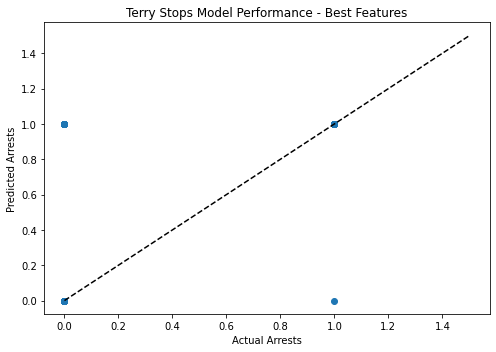

In [514]:
# Plot Models with Best Features
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_hat_feat)
plt.plot([0, 1.5], [0, 1.5], '--k')
plt.axis('tight')
plt.title('Terry Stops Model Performance - Best Features')
plt.xlabel('Actual Arrests')
plt.ylabel('Predicted Arrests')
plt.tight_layout()

### Fit Model Using Imbalanced Data (Original df not treated with SMOTE)

In [515]:
# Instantiate Model
unSmote_mod = GradientBoostingClassifier()

In [516]:
# Fit model
unSmote_mod.fit(X_train_all, y_train)

GradientBoostingClassifier()

In [517]:
# Make predictions
unSmote_ypred = unSmote_mod.predict(X_test_all)

### Evaluation Part 3: unSMOTE_mod (w/ all features)

In [518]:
# Print R^2 for the training data and testing data
unSmote_mod.score(X_train_all, y_train), unSmote_mod.score(X_test_all, y_test)

(0.9414218461355104, 0.942885234179478)

In [519]:
# Compute confusion matrix and print the classification report
cf_matrix = confusion_matrix(y_test, unSmote_ypred)
print('Confusion Matrix:\n', cf_matrix)
print('classification report:\n ', classification_report(y_test, unSmote_ypred))

Confusion Matrix:
 [[10543     2]
 [  637     6]]
classification report:
                precision    recall  f1-score   support

           0       0.94      1.00      0.97     10545
           1       0.75      0.01      0.02       643

    accuracy                           0.94     11188
   macro avg       0.85      0.50      0.49     11188
weighted avg       0.93      0.94      0.92     11188



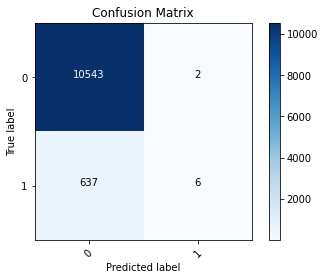

In [520]:
# Create the basic matrix
plt.imshow(cf_matrix,  cmap=plt.cm.Blues) 

# Add title and axis labels
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add appropriate axis scales
class_names = set(y) # Get class labels to add to matrix
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add labels to each cell
thresh = cf_matrix.max() / 2. # Used for text coloring below
# Here we iterate through the confusion matrix and append labels to our visualization 
for i, j in itertools.product(range(cf_matrix.shape[0]), range(cf_matrix.shape[1])):
        plt.text(j, i, cf_matrix[i, j],
                 horizontalalignment='center',
                 color='white' if cf_matrix[i, j] > thresh else 'black')

# Add a legend
plt.colorbar()
plt.show()

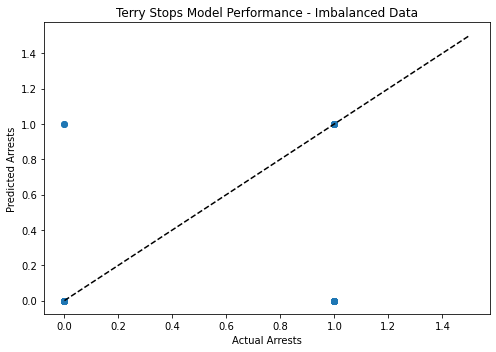

In [521]:
# Plot the model performance

plt.figure(figsize=(7, 5))
plt.scatter(y_test, unSmote_ypred)
plt.plot([0, 1.5], [0, 1.5], '--k')
plt.axis('tight')
plt.title('Terry Stops Model Performance - Imbalanced Data')
plt.xlabel('Actual Arrests')
plt.ylabel('Predicted Arrests')
plt.tight_layout()

Testing AUC: 0.8468673470064974


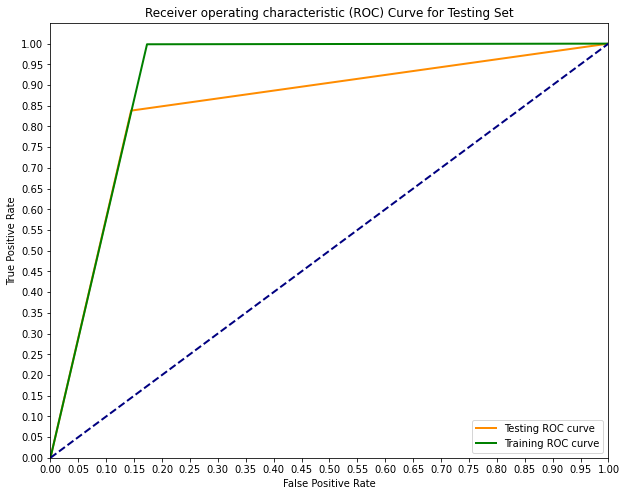

In [522]:

# Plot both the training and testing ROC and AUC

plt.figure(figsize=(10, 8))
lw = 2
plt.plot(false_positive_rate, true_positive_rate, color='darkorange',
         lw=lw, label='Testing ROC curve')
plt.plot(fpr, tpr, color='green',
         lw=lw, label='Training ROC curve')
fpr, tpr, thresh = roc_curve(y_train_resampled, y_scores)
rocauc = auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Testing Set')
plt.legend(loc='lower right')
print('Testing AUC: {}'.format(auc(false_positive_rate, true_positive_rate)))
plt.show()